In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy.stats import entropy
import networkit as nk #more efficient
import pickle
import statistics
from sklearn.utils import shuffle
from scipy.stats import pearsonr, spearmanr

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins,is_day,time_series_henColumn_tsRow, is_WG_open, is_day
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_tracking_date = config.li_tracking_date
print(id_run)
path_extracted_data_visual = os.path.join(path_extracted_data,'LongformatModels')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual):
    os.makedirs(path_extracted_data_visual)

change the configuration file if not done yet!
EXP2_


In [4]:
path_extracted_data

'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_'

In [5]:
#with weight on the edge: TODO AND READ
#https://stellargraph.readthedocs.io/en/stable/demos/node-classification/node2vec-weighted-node-classification.html

# download data

In [6]:
#new data
df_exp12 = pd.read_csv(os.path.join(path_extracted_data, 'df_bothexperiment.csv'), sep=',',
                         parse_dates=['level'], dayfirst=True) 
print(df_exp12.columns)
#keep only the HA from the corresponding timestamps
df_exp12['severity'] = df_exp12.apply(lambda x: x[x['HAID']+'_severity'], axis=1)
df_exp12['gap'] = df_exp12.apply(lambda x: x[x['HAID']+'_gap'], axis=1)
df_exp12['weight'] = df_exp12.apply(lambda x: x[x['HAID']+'_weight'], axis=1)
df_exp12['IsOFH'] = df_exp12['Treatment'].map(lambda x: x=='OFH')
display(df_exp12[['HA1_severity', 'HA2_severity','HA3_severity', 'HA4_severity','HA5_severity','severity','HAID']])
print(df_exp12.shape)
display(df_exp12.head(3))

Index(['DOA', 'Period_type', 'PenID', 'Is_relocated', 'time2event', 'level',
       'early_death', 'HenID', 'RPenID', 'Is2Experiment', 'Treatment',
       'mid_cum_Z4_h_Morning', 'WentinWG', 'Total_number_transition',
       'nbr_stays_1_Zone', 'vertical_travel_distance', 'duration_1_Zone_min',
       'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min',
       'duration_5_Zone_min', 'HA1_weight', 'HA2_weight', 'HA3_weight',
       'HA4_weight', 'HA1_severity', 'HA2_severity', 'HA3_severity',
       'HA4_severity', 'HA1_gap', 'HA2_gap', 'HA3_gap', 'HA4_gap',
       'HA1_FeatherDamage', 'HA2_FeatherDamage', 'HA3_FeatherDamage',
       'HA4_FeatherDamage', 'ExperimentID', 'daytimeduration',
       'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight', 'HA5_gap', 'HAID',
       'VTDperhour', 'Total_number_indoor_transition',
       'zonecrossed2transition'],
      dtype='object')


,HA1_severity,HA2_severity,HA3_severity,HA4_severity,HA5_severity,severity,HAID
0,0.0,0.0,1.0,18.0,NaN,0.0,HA1
1,0.0,0.0,1.0,18.0,NaN,0.0,HA1
2,0.0,0.0,1.0,18.0,NaN,0.0,HA1
3,0.0,0.0,1.0,18.0,NaN,0.0,HA1
4,0.0,0.0,1.0,18.0,NaN,0.0,HA1
...,...,...,...,...,...,...,...
8548,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8549,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8550,14.0,20.0,14.0,16.0,32.0,32.0,HA5
8551,14.0,20.0,14.0,16.0,32.0,32.0,HA5


(8553, 51)


,DOA,Period_type,PenID,Is_relocated,time2event,level,early_death,HenID,RPenID,Is2Experiment,...,HA5_weight,HA5_gap,HAID,VTDperhour,Total_number_indoor_transition,zonecrossed2transition,severity,gap,weight,IsOFH
0,167,R1,pen10,1,7,2021-11-23,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,HA1,3.185185,43.0,1.000000,0.0,0.0,1691.7,False
1,168,R1,pen10,1,6,2021-11-24,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,HA1,3.555556,45.0,1.066667,0.0,0.0,1691.7,False
2,169,R1,pen10,1,5,2021-11-25,0.0,EXP2_hen_1,Rpen12,1,...,NaN,NaN,HA1,4.592593,62.0,1.000000,0.0,0.0,1691.7,False


Index(['timepoint', 'group', 'age', 'day', 'date', 'file', 'pen', 'hybrid',
       'hen', 'severity', 'gap', 'durationC1', 'durationC2', 'durationC3',
       'durationC4', 'durationC5', 'durationC14', 'numberC1', 'numberC2',
       'numberC3', 'numberC4', 'numberC5', 'meanboutM1', 'medianboutM1',
       'meanboutM2', 'medianboutM2', 'meanboutM3', 'medianboutM3',
       'meanboutM4', 'medianboutM4', 'meanboutM5', 'medianboutM5', 'distance',
       'meanchange', 'mean1', 'medianchange', 'transitions', 'real0', 'sumdur',
       'nest_vs_total', 'PenID'],
      dtype='object')

pen1    1320
pen3    1320
pen5    1320
pen2    1320
pen4    1320
pen6    1320
Name: PenID, dtype: int64

pen5    1320
pen4    1320
pen6    1320
Name: PenID, dtype: int64

(3960, 51)


,timepoint,group,age,day,date,file,pen,hybrid,hen,severity,...,HenID,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,daytimeduration,ExperimentID,VTDperhour,Treatment
240,1,A,21,1,2016-10-27,1A41,5,LB,41,35.0,...,EXP3_hen_41,175.683333,96.783333,614.100000,70.800000,0.00,16,Exp3,2.875,groupA
241,1,A,21,2,2016-10-28,1A41,5,LB,41,35.0,...,EXP3_hen_41,68.633333,205.733333,632.333333,52.166667,0.35,16,Exp3,4.000,groupA
242,1,A,21,3,2016-10-29,1A41,5,LB,41,35.0,...,EXP3_hen_41,174.600000,124.483333,604.016667,53.633333,0.00,16,Exp3,3.625,groupA


,DOA,age,date,group
240,142,21,2016-10-27,A
241,143,21,2016-10-28,A
242,144,21,2016-10-29,A
243,145,21,2016-10-30,A
244,146,21,2016-10-31,A
...,...,...,...,...
7915,432,62,2017-08-13,B
7916,433,62,2017-08-14,B
7917,434,62,2017-08-15,B
7918,435,62,2017-08-16,B


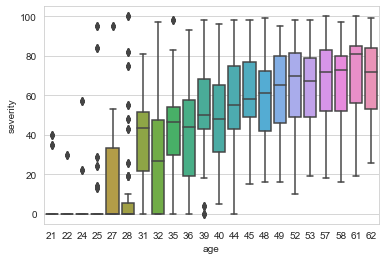

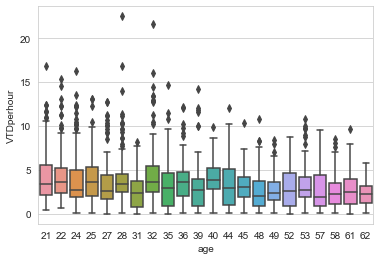

In [7]:
#past experiment
df_exp3 = pd.read_excel(os.path.join(path_extracted_data,'Mo_Masterfile.xlsx'),index_col=False)
df_exp3['PenID'] = df_exp3['pen'].map(lambda x: 'pen'+str(x))
display(df_exp3.columns)
#check penID
display(df_exp3['PenID'].value_counts())
df_exp3 = df_exp3[df_exp3['hybrid']=='LB']
display(df_exp3['PenID'].value_counts())
df_exp3['HenID'] = df_exp3['hen'].map(lambda x: 'EXP3_hen_'+str(x))
df_exp3['severity'] = df_exp3['severity'].map(lambda x: x*10) #scale as in our experiment
df_exp3['duration_1_Zone_min'] = df_exp3['durationC1'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_2_Zone_min'] = df_exp3['durationC2'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_3_Zone_min'] = df_exp3['durationC3'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_4_Zone_min'] = df_exp3['durationC4'].map(lambda x: x/60) #scale as in our experiment
df_exp3['duration_5_Zone_min'] = df_exp3['durationC5'].map(lambda x: x/60) #scale as in our experiment

df_exp3['daytimeduration'] = 16
df_exp3['ExperimentID'] = 'Exp3'
df_exp3['VTDperhour'] = df_exp3['distance'] /df_exp3['daytimeduration']
#df_exp3['proptime_2_Zone'] = df_exp3['duration_2_Zone_min'] / (df_exp3['daytimeduration']*60) *100
#df_exp3['proptime_5_Zone'] = df_exp3['duration_5_Zone_min'] / (df_exp3['daytimeduration']*60) *100
df_exp3['Treatment'] = df_exp3['group'].map(lambda x: 'group'+x)
print(df_exp3.shape)
#display(df_exp3[['daytimeduration','distance','VTDperhour','group',
#                 'duration_2_Zone_min','duration_5_Zone_min']].head(3))

#extract DOA (instead of the age here beeing weeks of age)
display(df_exp3.head(3))
df_exp3[df_exp3['age']==21]['date'].unique() 
#if hens were 21 week of age during these 6 days, lets assume they became 21WOA on the previous day : 
#dt.datetime(2016,10,26) hens were 141
#BUT BETTER: ask Rufener if she knows
df_exp3['DOA'] = df_exp3['date'].map(lambda x: int(141+(x-dt.datetime(2016,10,26)).days))
display(df_exp3[['DOA','age','date','group']])

df_exp3['early_death'] = 0 #to check with Christina
df_exp3['time2event'] = df_exp3['day'].map(lambda x: 7-x)
df_exp3['IsOFH'] = 0
df_exp3['Is_relocated'] = 0

df_exp3.rename(columns={'timepoint':'HAID','transitions':'Total_number_transition','meanchange':'zonecrossed2transition'}, inplace=True)
df_exp3['HAID'] = df_exp3['HAID'].map(lambda x: 'HA'+str(int(x)))
df_exp3['HAID'] = df_exp3.apply(lambda x: x['HAID']+x['group'], axis=1)
sns.boxplot(x='age',y='severity', data=df_exp3)
plt.show();
sns.boxplot(x='age',y='VTDperhour', data=df_exp3)
plt.show();

In [8]:
df_haage = df_exp3.groupby(['HAID'])['DOA'].agg(lambda x: max(set(x))+1).reset_index() #KBF done on the day after
df_haage['HAID'] = df_haage['HAID'].map(lambda x: 'Exp3_'+x)
display(df_haage)
dico_haexp3_age = dict(zip(df_haage['HAID'].tolist(),df_haage['DOA'].tolist()))
dico_haexp3_age

,HAID,DOA
0,Exp3_HA10A,400
1,Exp3_HA10B,409
2,Exp3_HA11A,428
3,Exp3_HA11B,437
4,Exp3_HA1A,148
5,Exp3_HA1B,156
6,Exp3_HA2A,169
7,Exp3_HA2B,177
8,Exp3_HA3A,190
9,Exp3_HA3B,198


{'Exp3_HA10A': 400,
 'Exp3_HA10B': 409,
 'Exp3_HA11A': 428,
 'Exp3_HA11B': 437,
 'Exp3_HA1A': 148,
 'Exp3_HA1B': 156,
 'Exp3_HA2A': 169,
 'Exp3_HA2B': 177,
 'Exp3_HA3A': 190,
 'Exp3_HA3B': 198,
 'Exp3_HA4A': 218,
 'Exp3_HA4B': 226,
 'Exp3_HA5A': 246,
 'Exp3_HA5B': 254,
 'Exp3_HA6A': 274,
 'Exp3_HA6B': 282,
 'Exp3_HA7A': 317,
 'Exp3_HA7B': 325,
 'Exp3_HA8A': 337,
 'Exp3_HA8B': 345,
 'Exp3_HA9A': 365,
 'Exp3_HA9B': 373}

In [9]:
#exp2
birth_date = dt.datetime(2021,6,9) #DOA 1 = 2021-6-10
li_ = [dt.datetime(2021,11,30), dt.datetime(2022,2,8), dt.datetime(2022,4,12), dt.datetime(2022,7,5)]
print([(i-birth_date).days for i in li_])
#exp1:
birth_date = dt.datetime(2020,6,3) #DOA 1 = 2020-6-4
li_ = [dt.datetime(2020,11,23), dt.datetime(2021,1,4), dt.datetime(2021,2,1),
               dt.datetime(2021,4,12), dt.datetime(2021,7,26)]
print([(i-birth_date).days for i in li_])

dico_haexp12_age = {'Exp2_HA1': 174,'Exp2_HA2': 244,'Exp2_HA3': 307,'Exp2_HA4': 391,
                    'Exp1_HA1':173, 'Exp1_HA2':215,'Exp1_HA3':243,'Exp1_HA4':313,'Exp1_HA5':418}
dico_ha_age = {**dico_haexp3_age, **dico_haexp12_age}
dico_ha_age
#lets define start date of study as 215, to inlude four timestamp from the studies, except exp 1 as to much correlated with time 
doa_studystarted = min(dico_ha_age.values()) #lets consider all #for now 190
doa_studystarted

[174, 244, 307, 391]
[173, 215, 243, 313, 418]


148

In [10]:
print(min(dico_ha_age.values()),max(dico_ha_age.values()),
      round(np.mean(list(dico_ha_age.values())),2),np.median(list(dico_ha_age.values())))

148 437 282.32 274.0


#what is durationC14
df_exp3['test'] = df_exp3[['durationC1','durationC2','durationC3','durationC4']].sum(axis=1)
display(df_exp3[[i for i in df_exp3.columns if 'duration' in i]+['test']])
df_exp3[df_exp3['test2']!=df_exp3['durationC14']] #wohoooo thats what it is

# combine together

In [11]:
df_exp12.columns

Index(['DOA', 'Period_type', 'PenID', 'Is_relocated', 'time2event', 'level',
       'early_death', 'HenID', 'RPenID', 'Is2Experiment', 'Treatment',
       'mid_cum_Z4_h_Morning', 'WentinWG', 'Total_number_transition',
       'nbr_stays_1_Zone', 'vertical_travel_distance', 'duration_1_Zone_min',
       'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min',
       'duration_5_Zone_min', 'HA1_weight', 'HA2_weight', 'HA3_weight',
       'HA4_weight', 'HA1_severity', 'HA2_severity', 'HA3_severity',
       'HA4_severity', 'HA1_gap', 'HA2_gap', 'HA3_gap', 'HA4_gap',
       'HA1_FeatherDamage', 'HA2_FeatherDamage', 'HA3_FeatherDamage',
       'HA4_FeatherDamage', 'ExperimentID', 'daytimeduration',
       'HA5_FeatherDamage', 'HA5_severity', 'HA5_weight', 'HA5_gap', 'HAID',
       'VTDperhour', 'Total_number_indoor_transition',
       'zonecrossed2transition', 'severity', 'gap', 'weight', 'IsOFH'],
      dtype='object')

In [12]:
######################################################################################
#concat both dataset
li_mvtha = ['VTDperhour','zonecrossed2transition','severity','gap']
li_info = ['HenID','early_death','ExperimentID','DOA','time2event','HAID','Is_relocated','IsOFH']
li_unevecomput = ['duration_1_Zone_min','duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min','duration_5_Zone_min']
print(df_exp12.shape)
#display(df_exp12[li_mvtha+li_info].head(2))
print(df_exp3.shape)
#display(df_exp3[li_mvtha+li_info].head(2))
df = pd.concat([df_exp12[li_mvtha+li_info+['weight']+li_unevecomput], 
                df_exp3[li_mvtha+li_info+li_unevecomput]])
print(df.shape)
display(df.head(2))

(8553, 51)
(3960, 56)
(12513, 18)


,VTDperhour,zonecrossed2transition,severity,gap,HenID,early_death,ExperimentID,DOA,time2event,HAID,Is_relocated,IsOFH,weight,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min
0,3.185185,1.000000,0.0,0.0,EXP2_hen_1,0.0,Exp2,167,7,HA1,1,0,1691.7,0.0,535.966667,201.916667,55.800000,16.316667
1,3.555556,1.066667,0.0,0.0,EXP2_hen_1,0.0,Exp2,168,6,HA1,1,0,1691.7,0.0,410.600000,171.883333,53.783333,173.733333


# compute unevenness

In [13]:
print(df.shape)
df = df[~df['duration_2_Zone_min'].isnull()]
print(df.shape)

(12513, 18)
(12045, 18)


In [14]:
li_space = [3.726,16.100,5.819,2.152+1.472,4.531]
def unevenness(li_propzones,li_expected):
    '''compute the following distance: d(x,y) = sum( abs(xi-yi) / (yi) ) / n'''
    n = len(li_propzones)
    if n!=len(li_expected):
        print('your two vectors must have same length')
        sys.exit()
    #ensure the vectors are normalized (sum to 1)
    li_propzones = [i/sum(li_propzones) for i in li_propzones]
    li_expected = [i/sum(li_expected) for i in li_expected]
    d = sum([abs(li_propzones[i]-li_expected[i]) / li_expected[i] for i in range(n)])/n
    return(d)

li_propzones = [0.3,0.2,0.4,0.5,0.5]
li_propzones = [i/sum(li_propzones) for i in li_propzones]
li_normspace = [i/sum(li_space) for i in li_space]
print(li_propzones)
print(li_normspace)
lexpected = []
print(unevenness(li_propzones=li_propzones,li_expected=li_normspace))

[0.15789473684210525, 0.10526315789473685, 0.2105263157894737, 0.2631578947368421, 0.2631578947368421]
[0.11023668639053255, 0.47633136094674566, 0.1721597633136095, 0.10721893491124261, 0.13405325443786983]
0.7703348344929435


In [15]:
li_dur = [i for i in df.columns if 'duration_' in i]
print(li_dur)
df['sumdur'] = df[li_dur].sum(axis=1)
display(df[['sumdur']+li_dur].head(3))
for i in li_dur:
    df['Prop'+i.replace('duration_','Z').replace('_Zone_min','')] = df.apply(lambda x: x[i]/x['sumdur'], axis=1)
li_prop = [i for i in df.columns if i.startswith('Prop')]
display(df[li_prop].head(3))

['duration_1_Zone_min', 'duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min', 'duration_5_Zone_min']


,sumdur,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min
0,810.0,0.0,535.966667,201.916667,55.800000,16.316667
1,810.0,0.0,410.600000,171.883333,53.783333,173.733333
2,810.0,0.0,478.016667,220.283333,56.600000,55.100000


,PropZ1,PropZ2,PropZ3,PropZ4,PropZ5
0,0.0,0.661687,0.249280,0.068889,0.020144
1,0.0,0.506914,0.212202,0.066399,0.214486
2,0.0,0.590144,0.271955,0.069877,0.068025


In [16]:
# to avoid that hens staying most day in the litter is treated the same as hens staying most day on the top tier,
# we will compute in terms of m^2
df['dur_values_norm'] = df.apply(lambda x: [x['PropZ1'], x['PropZ2'], x['PropZ3'], x['PropZ4'], x['PropZ5']], axis=1)
df['unevenness'] = df['dur_values_norm'].map(lambda x: unevenness(x,li_normspace))
li_mvtha = li_mvtha+['unevenness']

In [17]:
#maybe max
l1 = [0,0,0,1,0]
li_space = [3.726,16.100,5.819,2.152+1.472,4.531]
l2 = [round(i/sum(li_space),2) for i in li_space]
print(l1)
print(l2)
print(unevenness(l1,l2))

[0, 0, 0, 1, 0]
[0.11, 0.48, 0.17, 0.11, 0.13]
2.4181818181818184


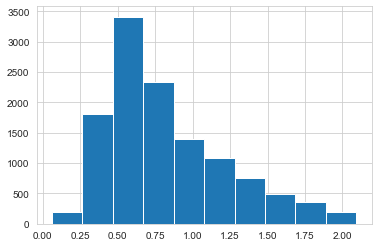

In [18]:
plt.hist(df['unevenness']);

In [19]:
dico_prop_name = {'PropZ1':'WG', 'PropZ2':'literred floor','PropZ3':'lower tier','PropZ4':'nestbox tier','PropZ5':'top tier'}

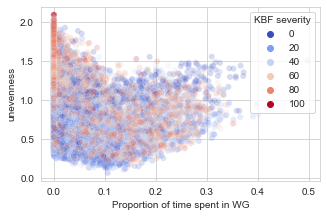

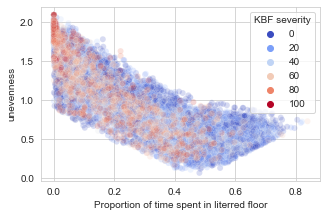

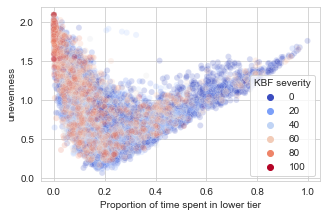

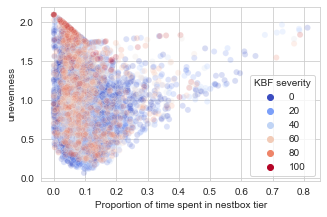

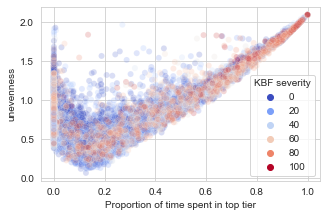

In [20]:
# visual
df_plt = df.copy()
df_plt.rename(columns={'severity': 'KBF severity'}, inplace=True)
for i in li_prop:
    plt.figure(figsize=(5,3.2))
    sns.scatterplot(y='unevenness', x=i, hue='KBF severity', data=df_plt, palette=sns.color_palette("coolwarm", as_cmap=True),
                    alpha=0.2);
    plt.xlabel('Proportion of time spent in '+dico_prop_name[i])
    plt.savefig(os.path.join(path_extracted_data_visual,'scatterplot_unevenness_'+i+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()

(100, 7)


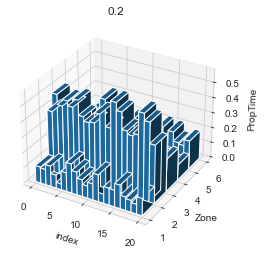

(100, 7)


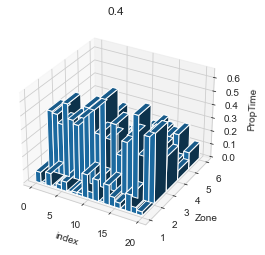

(100, 7)


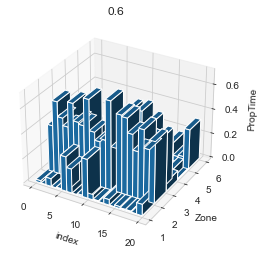

(100, 7)


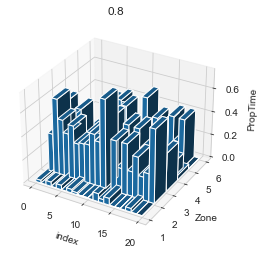

(100, 7)


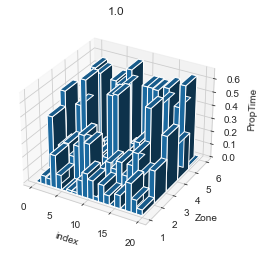

(100, 7)


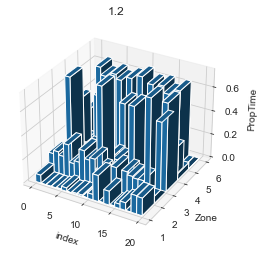

(100, 7)


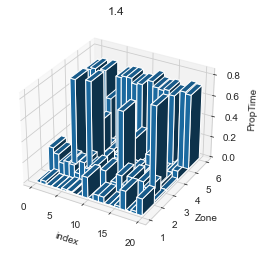

(100, 7)


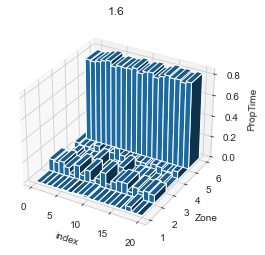

(100, 7)


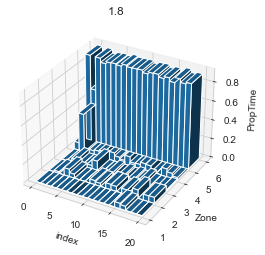

(100, 7)


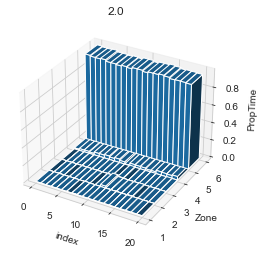

(200, 9)


,unevenness,DOA,severity,PropZ1,PropZ2,PropZ3,PropZ4,PropZ5,index
5584,0.2,343,81.0,0.107541,0.402921,0.147647,0.158717,0.183174,0
4169,0.2,281,74.0,0.101938,0.522689,0.208500,0.117814,0.049059,1


C:\Users\camil\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
C:\Users\camil\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


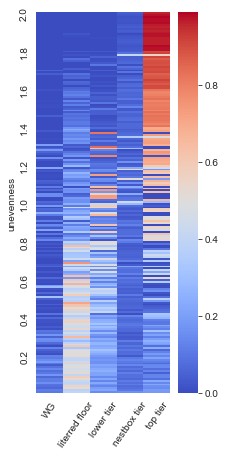

In [21]:
li_df = []
nbr = 20
rs = 0
df_plt_ = df[['unevenness','DOA','severity']+li_prop].copy()
df_plt_['unevenness'] = df_plt_['unevenness'].map(lambda x: round(x,1))
df_plt_ = shuffle(df_plt_, random_state=rs)
for i in range(0,25,2):
    df_plt = df_plt_.copy()
    df_plt = df_plt[df_plt['unevenness']==i/10].iloc[0:nbr]
    if df_plt.shape[0]==nbr:
        fig = plt.figure()
        ax1 = fig.add_subplot(111, projection='3d')
        li_df.append(df_plt)
        df_plt['index'] = range(0,df_plt.shape[0])
        df_plt = pd.melt(df_plt, id_vars=['DOA','unevenness','severity','index'], value_vars=li_prop, value_name='PropTime')
        df_plt['Zone'] = df_plt['variable'].map(lambda x: int(re.findall(r'\d+',x)[0]))
        #df_plt.sort_values('',inplace=True, ascending=False)
        print(df_plt.shape)
        df_plt.head(2)
        x3 = df_plt['index'].tolist()
        y3 = df_plt['Zone'].tolist() 
        z3 = np.zeros(len(x3)) #start at 0 on the z axis

        #x, dy, dz represent the width, depth, and height (dimensions in x, y and z)
        dx = np.ones(len(x3))
        dy = np.ones(len(x3))
        dz = df_plt['PropTime'].tolist() #chose the height of the z axis
        ax1.bar3d(x3, y3, z3, dx, dy, dz)
        ax1.set_xlabel('index')
        ax1.set_ylabel('Zone')
        ax1.set_zlabel('PropTime')
        plt.title(i/10)
        plt.show()
df_hm = pd.concat([li_df[0],li_df[1]])
for i in range(2,len(li_df)):
    df_hm = pd.concat([df_hm,li_df[i]])
print(df_hm.shape)
display(df_hm.head(2))
df_hm.sort_values('unevenness',ascending=False,inplace=True)
li_prop = ['PropZ1','PropZ2','PropZ3','PropZ4','PropZ5']
M = df_hm[li_prop]
plt.figure(figsize=(3,7))
sns.heatmap(M, xticklabels=[dico_prop_name[i] for i in li_prop], 
            yticklabels=[df_hm['unevenness'].tolist()[i] if i%20==0 else '' for i in range(0,df_hm.shape[0])], 
            cmap=sns.color_palette("coolwarm", as_cmap=True),annot=False) #to annotate value in each cell
plt.xticks(rotation=55)
plt.ylabel('unevenness')
plt.savefig(os.path.join(path_extracted_data_visual,'Heatmap_unevenness_'+str(rs)+'.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

In [22]:
#compared to the daily mean? mean of another flock? of all data? 
#or square meter to use no other prior info than the structure itself? easier to interpret, thats what I'll do
df[li_prop].describe()

,PropZ1,PropZ2,PropZ3,PropZ4,PropZ5
count,12045.000000,12045.000000,12045.000000,12045.000000,12045.000000
mean,0.050860,0.342462,0.236883,0.080886,0.288909
std,0.073460,0.189329,0.163835,0.062505,0.272572
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.186074,0.115390,0.045870,0.048730
50%,0.016331,0.360535,0.219093,0.065648,0.206630
75%,0.068936,0.495778,0.321259,0.095972,0.475413
max,0.497808,0.839528,0.997552,0.816444,1.000000


In [23]:
#then drop 
print(df.shape)
df.drop([i for i in df.columns if (('durationC' in i) | ('duration_' in i))],axis=1, inplace=True)
print(df.shape)

(12045, 26)
(12045, 21)


# last processing & save

In [24]:
######################################################################################
#add usefull var
df['IsOFH'] = df['IsOFH'].map(lambda x: int(x))
df['Is_exp3'] = df['ExperimentID'].map(lambda x: int(x=='Exp3'))
df['Is_exp2'] = df['ExperimentID'].map(lambda x: int(x=='Exp2'))
df['Is_exp1'] = df['ExperimentID'].map(lambda x: int(x=='Exp1'))
display(df[['IsOFH','ExperimentID', 'Is_relocated','Is_exp1','Is_exp2','Is_exp3']])
df['DOAHA'] = df.apply(lambda x: dico_ha_age[x['ExperimentID']+'_'+x['HAID']], axis=1)

######################################################################################
print('---------------- remove any NA in severity of VTDperhour')
display(df.isna().sum(axis=0).sort_values())
print(df.shape)
df = df[~df['VTDperhour'].isnull()]
print(df.shape)
print(df.shape)
df = df[~df['severity'].isnull()]
print(df.shape)
display(df.isna().sum(axis=0).sort_values())

######################################################################################
print('---------------- keep all DOA >=doa_studystarted, then add MonthInStudy')
df = df[df['DOAHA']>=doa_studystarted].copy()
print(df.shape)

######################################################################################
#MonthInstudy: the time when the measurement took place (e.g., in months from the beginning of the study)
df['MonthInstudy'] = df['DOAHA'].map(lambda x: round((x-doa_studystarted)/30.4167,2))
if df['MonthInstudy'].min()!=0:
    print('error')
    sys.exit()
display(df.groupby('HenID')[['HAID','DOAHA','MonthInstudy']].agg(lambda x: sorted(set(x))).reset_index())
display(df.head(3))

,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,Is_exp3
0,0,Exp2,1,0,1,0
1,0,Exp2,1,0,1,0
2,0,Exp2,1,0,1,0
3,0,Exp2,1,0,1,0
4,0,Exp2,1,0,1,0
...,...,...,...,...,...,...
7915,0,Exp3,0,0,0,1
7916,0,Exp3,0,0,0,1
7917,0,Exp3,0,0,0,1
7918,0,Exp3,0,0,0,1


---------------- remove any NA in severity of VTDperhour


VTDperhour                   0
Is_exp2                      0
Is_exp3                      0
unevenness                   0
dur_values_norm              0
PropZ5                       0
PropZ4                       0
PropZ3                       0
PropZ2                       0
PropZ1                       0
sumdur                       0
Is_exp1                      0
DOAHA                        0
Is_relocated                 0
HAID                         0
time2event                   0
DOA                          0
ExperimentID                 0
early_death                  0
HenID                        0
IsOFH                        0
zonecrossed2transition      16
gap                         63
severity                    63
weight                    3609
dtype: int64

(12045, 25)
(12045, 25)
(12045, 25)
(11982, 25)


VTDperhour                   0
Is_exp2                      0
Is_exp3                      0
unevenness                   0
dur_values_norm              0
PropZ5                       0
PropZ4                       0
PropZ3                       0
PropZ2                       0
PropZ1                       0
sumdur                       0
Is_exp1                      0
DOAHA                        0
Is_relocated                 0
HAID                         0
time2event                   0
DOA                          0
ExperimentID                 0
early_death                  0
HenID                        0
gap                          0
severity                     0
IsOFH                        0
zonecrossed2transition      16
weight                    3592
dtype: int64

---------------- keep all DOA >=doa_studystarted, then add MonthInStudy
(11982, 25)


,HenID,HAID,DOAHA,MonthInstudy
0,EXP1_hen_1,"[HA1, HA2]","[173, 215]","[0.82, 2.2]"
1,EXP1_hen_10,"[HA1, HA2, HA3, HA4, HA5]","[173, 215, 243, 313, 418]","[0.82, 2.2, 3.12, 5.42, 8.88]"
2,EXP1_hen_100,[HA1],[173],[0.82]
3,EXP1_hen_101,"[HA1, HA2, HA3, HA4, HA5]","[173, 215, 243, 313, 418]","[0.82, 2.2, 3.12, 5.42, 8.88]"
4,EXP1_hen_102,"[HA1, HA2, HA3, HA4, HA5]","[173, 215, 243, 313, 418]","[0.82, 2.2, 3.12, 5.42, 8.88]"
...,...,...,...,...
431,EXP3_hen_95,"[HA10B, HA11B, HA1B, HA2B, HA3B, HA4B, HA5B, H...","[156, 177, 198, 226, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82, 6.4..."
432,EXP3_hen_96,"[HA10B, HA1B, HA2B, HA3B, HA4B, HA5B, HA6B, HA...","[156, 177, 198, 226, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82, 6.4..."
433,EXP3_hen_97,"[HA10B, HA11B, HA1B, HA2B, HA3B, HA4B, HA5B, H...","[156, 177, 198, 226, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82, 6.4..."
434,EXP3_hen_98,"[HA10B, HA11B, HA1B, HA2B, HA3B, HA4B, HA5B, H...","[156, 177, 198, 226, 254, 282, 325, 345, 373, ...","[0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82, 6.4..."


,VTDperhour,zonecrossed2transition,severity,gap,HenID,early_death,ExperimentID,DOA,time2event,HAID,...,PropZ3,PropZ4,PropZ5,dur_values_norm,unevenness,Is_exp3,Is_exp2,Is_exp1,DOAHA,MonthInstudy
0,3.185185,1.000000,0.0,0.0,EXP2_hen_1,0.0,Exp2,167,7,HA1,...,0.249280,0.068889,0.020144,"[0.0, 0.6616872427983539, 0.24927983539094645,...",0.608863,0,1,0,174,0.85
1,3.555556,1.066667,0.0,0.0,EXP2_hen_1,0.0,Exp2,168,6,HA1,...,0.212202,0.066399,0.214486,"[0.0, 0.5069135802469136, 0.21220164609053496,...",0.455501,0,1,0,174,0.85
2,4.592593,1.000000,0.0,0.0,EXP2_hen_1,0.0,Exp2,169,5,HA1,...,0.271955,0.069877,0.068025,"[0.0, 0.5901440329218107, 0.27195473251028807,...",0.531887,0,1,0,174,0.85


In [25]:
######################################################################################
print('---------------- remove all the hens with only one or two measure')
df_sel = df.groupby('HenID')['HAID'].agg(lambda x: len(set(x))).reset_index()
li_hen2remove = df_sel[df_sel['HAID']<=2]['HenID'].tolist() #remove all the hens with only one or two measure
print(len(set(li_hen2remove)))
print(df.shape)
df = df[~df['HenID'].isin(li_hen2remove)]
print(df.shape)

######################################################################################
#remove hens with only one obs, model do not like it otherwise
print('---------------- remove hens with no SD')
df_ = df.groupby('HenID')[['severity','VTDperhour']].agg(lambda x: np.std(list(x))).reset_index()
display(df_[df_['severity']==0])
li_hen2remove = list(set(df_[df_['severity']==0]['HenID'].tolist()))
print(len(li_hen2remove))
df = df[~df['HenID'].isin(li_hen2remove)]
print(df.shape)

######################################################################################
#in ctsem documentation: "subject id (numeric values, 1 to max subjects)
print('---------------- now that we cleaned the data, lets add a subject id that comply with ctsem package in R to avoid potential confusion')
df_h = df[['HenID']].drop_duplicates()
df_h['id'] = range(1,df_h.shape[0]+1)
dico_henID_ctsemid = dict(zip(df_h['HenID'].tolist(),df_h['id'].tolist()))
df['id'] = df['HenID'].map(lambda x: dico_henID_ctsemid[x])
display(df[['HenID','id']].head(2))
display(df[['ExperimentID','HAID']].value_counts().reset_index())
display(df[['ExperimentID','MonthInstudy']].value_counts().reset_index())

######################################################################################
print('---------------- save with mvt every day and mean mvt per HA')
print(df.shape)
display(df.head(2))
df.to_csv(os.path.join(path_extracted_data,'df_longformatALLdaily.csv'), index=False, sep=',')
print(spearmanr(df['severity'].tolist(), df['MonthInstudy'].tolist()))
print(pearsonr(df['severity'].tolist(), df['MonthInstudy'].tolist()))
#groupby occasion to have a single mean mvt behaviour per occasion (as we have a single HA per occasion, happening at the end
#of each occasion)
df_longformat = df.groupby(['HAID','HenID','id','MonthInstudy','DOAHA','IsOFH','ExperimentID', 'Is_relocated','Is_exp1','Is_exp2','Is_exp3',
                            'early_death'])[['time2event','DOA','PropZ5','VTDperhour','zonecrossed2transition',
                                             'unevenness', 'severity','gap','weight']].mean().reset_index()
#to avoid future confusion
df_longformat.rename(columns={'DOA':'meanDOAmvt'}, inplace=True)
#check correlation --> account for age trend
print(spearmanr(df_longformat['severity'].tolist(), df_longformat['MonthInstudy'].tolist()))
print(pearsonr(df_longformat['severity'].tolist(), df_longformat['MonthInstudy'].tolist()))

####################
#We will have time reflecting age, we will create an empty observation row for every hen at the age of your earliest 
#observation -- so as not all hens had their healh assessed at doa_studystarted, we will create an observation at 148 DOA for all the 
#other hens and just set the observed variables to NA.
len(df_longformat[df_longformat['DOAHA']==doa_studystarted]['HenID'].unique())
#display(df_longformat.groupby('DOAHA')['HenID'].agg(lambda x: len(set(x))).reset_index()) #more details if we want more than 19 hens
li_firsthens = df_longformat[df_longformat['DOAHA']==doa_studystarted]['HenID'].tolist()
li_otherhens = [i for i in df_longformat['HenID'].unique() if i not in li_firsthens]
print(len(li_firsthens), len(df_longformat['HenID'].unique()), len(li_otherhens))
li_specifichens = ['HenID','id','IsOFH','ExperimentID','Is_relocated','Is_exp1','Is_exp2','Is_exp3','early_death']
dfhens = {'HenID': li_otherhens,
          'MonthInstudy':0,
          'DOAHA':doa_studystarted,
          'severity':np.nan,
          'VTDperhour':np.nan,
          'PropZ5':np.nan,
          'unevenness':np.nan,
          'zonecrossed2transition':np.nan,
          'HAID':'created'}
df_2add = pd.DataFrame.from_dict(dfhens)
#add hens data
df_specifichens = df[li_specifichens].drop_duplicates()
if df_specifichens.shape[0]!=len(df_specifichens['HenID'].unique()):
    print('ERROR: some ind do not have unique values for at least one of the characteristics')
df_2add = pd.merge(df_2add, df_specifichens, on='HenID', how='left')
print(df_2add.shape)
display(df_2add.head(2))

print(df_longformat.shape)
df_longformat = pd.concat([df_longformat,df_2add])
print(df_longformat.shape, df_2add.shape)

#fill nan with time2event otherwise: NA's in TDpreds! Replaced by zeroes, consider appropriateness...
v = df_longformat['time2event'].mean()
print(v)
df_longformat.loc[df_longformat['time2event'].isnull(),'time2event'] = v

#groupby fucked the id, lets sort by id
df_longformat.loc[df_longformat['ExperimentID']=='Exp2','zonecrossed2transition'] = np.nan
df_longformat.sort_values(['id','MonthInstudy'], inplace=True)
print(df_longformat.shape)
display(df_longformat.head(2))
df_longformat.to_csv(os.path.join(path_extracted_data,'df_longformatALL.csv'), index=False, sep=',')

---------------- remove all the hens with only one or two measure
60
(11982, 26)
(11434, 26)
---------------- remove hens with no SD


,HenID,severity,VTDperhour
25,EXP1_hen_135,0.0,0.815649
59,EXP1_hen_173,0.0,0.796409
98,EXP1_hen_39,0.0,0.214810
185,EXP2_hen_129,0.0,0.479776


4
(11353, 26)
---------------- now that we cleaned the data, lets add a subject id that comply with ctsem package in R to avoid potential confusion


,HenID,id
0,EXP2_hen_1,1
1,EXP2_hen_1,1


,ExperimentID,HAID,0
0,Exp2,HA3,1127
1,Exp2,HA1,1106
2,Exp2,HA4,1087
3,Exp2,HA2,991
4,Exp1,HA1,924
5,Exp1,HA2,894
6,Exp1,HA4,845
7,Exp1,HA5,669
8,Exp3,HA5B,240
9,Exp3,HA4B,240


,ExperimentID,MonthInstudy,0
0,Exp2,5.23,1127
1,Exp2,0.85,1106
2,Exp2,7.99,1087
3,Exp2,3.16,991
4,Exp1,0.82,924
5,Exp1,2.20,894
6,Exp1,5.42,845
7,Exp1,8.88,669
8,Exp3,3.48,240
9,Exp3,2.56,240


---------------- save with mvt every day and mean mvt per HA
(11353, 27)


,VTDperhour,zonecrossed2transition,severity,gap,HenID,early_death,ExperimentID,DOA,time2event,HAID,...,PropZ4,PropZ5,dur_values_norm,unevenness,Is_exp3,Is_exp2,Is_exp1,DOAHA,MonthInstudy,id
0,3.185185,1.000000,0.0,0.0,EXP2_hen_1,0.0,Exp2,167,7,HA1,...,0.068889,0.020144,"[0.0, 0.6616872427983539, 0.24927983539094645,...",0.608863,0,1,0,174,0.85,1
1,3.555556,1.066667,0.0,0.0,EXP2_hen_1,0.0,Exp2,168,6,HA1,...,0.066399,0.214486,"[0.0, 0.5069135802469136, 0.21220164609053496,...",0.455501,0,1,0,174,0.85,1


SpearmanrResult(correlation=0.6215005720421344, pvalue=0.0)
PearsonRResult(statistic=0.4957900452395684, pvalue=0.0)
SpearmanrResult(correlation=0.615622101736272, pvalue=5.156778447484433e-196)
PearsonRResult(statistic=0.5052108429169454, pvalue=5.080041442749007e-122)
19 372 353
(353, 17)


,HenID,MonthInstudy,DOAHA,severity,VTDperhour,PropZ5,unevenness,zonecrossed2transition,HAID,id,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,Is_exp3,early_death
0,EXP1_hen_10,0,148,NaN,NaN,NaN,NaN,NaN,created,183,1,Exp1,0,1,0,0,0.0
1,EXP1_hen_101,0,148,NaN,NaN,NaN,NaN,NaN,created,260,1,Exp1,0,1,0,0,0.0


(1875, 21)
(2228, 21) (353, 17)
3.7316088888888888
(2228, 21)


,HAID,HenID,id,MonthInstudy,DOAHA,IsOFH,ExperimentID,Is_relocated,Is_exp1,Is_exp2,...,early_death,time2event,meanDOAmvt,PropZ5,VTDperhour,zonecrossed2transition,unevenness,severity,gap,weight
132,created,EXP2_hen_1,1,0.00,148,0,Exp2,1,0,1,...,0.0,3.731609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,HA1,EXP2_hen_1,1,0.85,174,0,Exp2,1,0,1,...,0.0,4.000000,170.0,0.142936,3.680272,NaN,0.495648,0.0,0.0,1691.7


In [54]:
print(len(df_longformat['MonthInstudy'].unique()))
df_longformat['test_weeksinbarn'] = df_longformat['MonthInstudy'].map(lambda x: round(x*4.3,0))
print(len(df_longformat['test_weeksinbarn'].unique()))
df_longformat['test_weeksinbarn'].unique()

31
28


array([ 0.,  1.,  3.,  4.,  6.,  7.,  9., 10., 11., 13., 14., 15., 18.,
       19., 22., 23., 24., 25., 27., 28., 31., 32., 34., 36., 37., 38.,
       40., 41.])

In [55]:
df_longformat['test_MonthInstudyround'] = df_longformat['MonthInstudy'].map(lambda x: round(x,2))
print(len(df_longformat['test_MonthInstudyround'].unique()))
df_longformat['test_MonthInstudyround'].unique()

31


array([0.  , 0.26, 0.69, 0.82, 0.85, 0.95, 1.38, 1.64, 2.2 , 2.3 , 2.56,
       3.12, 3.16, 3.22, 3.48, 4.14, 4.41, 5.23, 5.42, 5.56, 5.82, 6.21,
       6.48, 7.13, 7.4 , 7.99, 8.28, 8.58, 8.88, 9.21, 9.5 ])

In [56]:
df_longformat.to_csv(os.path.join(path_extracted_data,'df_longformatALL.csv'), index=False, sep=',')

,MonthInstudy,ExperimentID


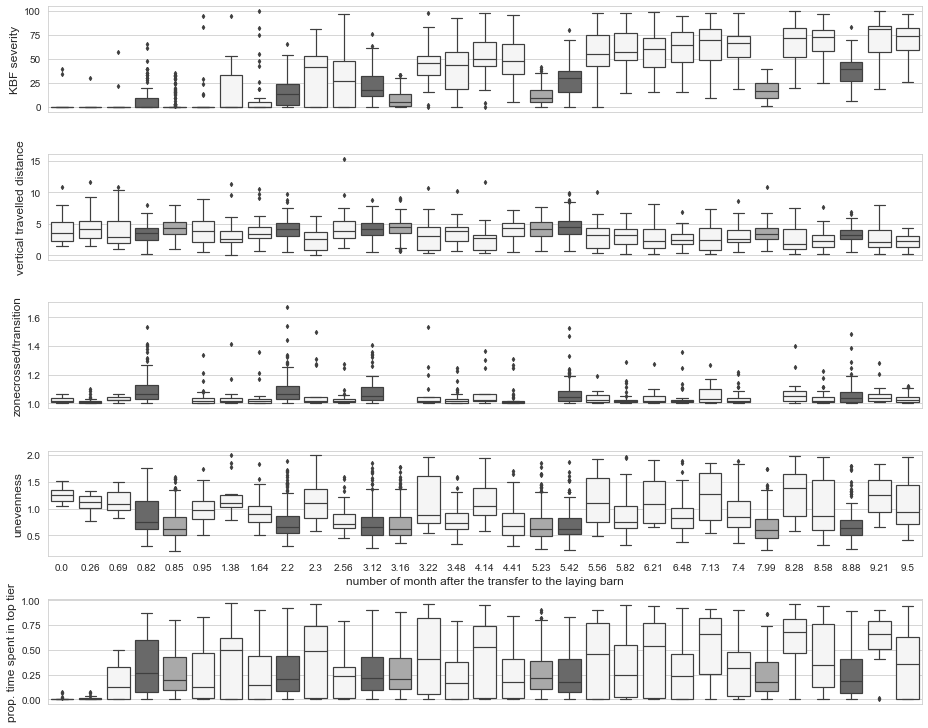

In [26]:
c = 1 ; l = 5 ; img_w = 13 ; img_h = 2
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
df_plt = df_longformat.copy()
df_ = df_plt[~df_plt['severity'].isnull()].groupby('MonthInstudy')['ExperimentID'].agg(lambda x: len(set(x))==1).reset_index()
display(df_[~df_['ExperimentID']]) #month in study is always different, none have more than one experimnet
#therefore lets take a dico
dico_month_exp = dict(zip(df_plt['MonthInstudy'],df_plt['ExperimentID']))
dico_month_exp
dico_exp_color = {'Exp3':'whitesmoke','Exp2':'darkgrey','Exp1':'dimgrey'}
my_pal = {x:dico_exp_color[dico_month_exp[x]] for x in df.MonthInstudy.unique()}
for t,name in zip(['severity','VTDperhour','zonecrossed2transition','unevenness','PropZ5'],['KBF severity', 'vertical travelled distance','zonecrossed/transition','unevenness','prop. time spent in top tier']):
    plt.subplot(l,c,i)
    ax = sns.boxplot(y=t, x='MonthInstudy', data=df_plt, palette=my_pal, fliersize=3, linewidth=1.2) #hue='ExperimentID', palette='Greys_r',
    #plt.axis('off');
    if i!=4:
        plt.xticks([]) #remove xlabel annotations
        plt.xlabel('')
    if i==4:
        #li_ = df_plt['MonthInstudy'].tolist()
        #ax.set_xticks(df_plt['MonthInstudy'].tolist(), [li_[i] if i%% for i in range(len(li_))])
        plt.xlabel('number of month after the transfer to the laying barn', size=12)
    if i!=1:
        plt.legend([],[], frameon=False)
    plt.ylabel(name, size=12)
    plt.tight_layout()
    i = i+1
plt.savefig(os.path.join(path_extracted_data_visual,'All_overtime.png'),dpi=300,format='png',bbox_inches='tight')

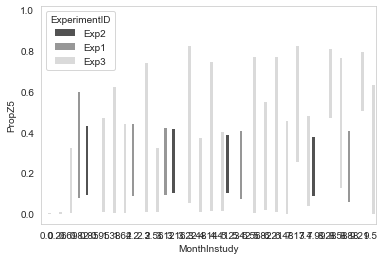

In [27]:
#just for color per experiment
sns.boxplot(y=t, x='MonthInstudy', data=df_plt, hue='ExperimentID', palette='Greys_r', fliersize=0, linewidth=0) #hue='ExperimentID', palette='Greys_r',
plt.grid(False)
plt.savefig(os.path.join(path_extracted_data_visual,'expID_colorlegend.png'),dpi=300,format='png',bbox_inches='tight')

In [28]:
#any DOA with HA from two experiemnts?
df_longformat.groupby('MonthInstudy')['ExperimentID'].agg(lambda x: set(x)).reset_index()

,MonthInstudy,ExperimentID
0,0.00,"{Exp2, Exp1, Exp3}"
1,0.26,{Exp3}
2,0.69,{Exp3}
3,0.82,{Exp1}
4,0.85,{Exp2}
5,0.95,{Exp3}
6,1.38,{Exp3}
7,1.64,{Exp3}
8,2.20,{Exp1}
9,2.30,{Exp3}


In [29]:
#any DOA with HA from two experiemnts?
df_longformat.groupby('DOAHA')['ExperimentID'].agg(lambda x: set(x)).reset_index()

,DOAHA,ExperimentID
0,148,"{Exp2, Exp1, Exp3}"
1,156,{Exp3}
2,169,{Exp3}
3,173,{Exp1}
4,174,{Exp2}
5,177,{Exp3}
6,190,{Exp3}
7,198,{Exp3}
8,215,{Exp1}
9,218,{Exp3}


In [30]:
#lets define time as the number of month sign the first KBF, and each time beeing representative of the day of KBF, 
#not the day of mvt
df_longformat[['ExperimentID','HAID']].value_counts().reset_index()

,ExperimentID,HAID,0
0,Exp2,HA3,162
1,Exp2,created,162
2,Exp2,HA1,158
3,Exp2,HA2,158
4,Exp2,HA4,156
5,Exp1,created,150
6,Exp1,HA2,149
7,Exp1,HA4,136
8,Exp1,HA1,132
9,Exp1,HA3,116


In [31]:
#altogether
df_longformat.sort_values(['DOAHA'], inplace=True)
df_ = df_longformat.groupby(['HenID','ExperimentID'])[['DOAHA','MonthInstudy','severity',
                                     'Is_exp2','Is_exp3','IsOFH']].agg(lambda x: list(x)).reset_index()
df_['DOAdiff'] = df_['DOAHA'].map(lambda x: [x[i+1]-x[i] for i in range(0,len(x)-1)])
df_['is_created'] = df_['severity'].map(lambda x: [math.isnan(i) for i in x])
df_['is_created'] = df_['is_created'].map(lambda x: str(x))
df_['DOAHA'] = df_['DOAHA'].map(lambda x: str(x))
df_['MonthInstudy'] = df_['MonthInstudy'].map(lambda x: str(x))

df_

,HenID,ExperimentID,DOAHA,MonthInstudy,severity,Is_exp2,Is_exp3,IsOFH,DOAdiff,is_created
0,EXP1_hen_10,Exp1,"[148, 173, 215, 243, 313, 418]","[0.0, 0.82, 2.2, 3.12, 5.42, 8.88]","[nan, 34.0, 30.0, 32.0, 38.0, 40.0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1]","[25, 42, 28, 70, 105]","[True, False, False, False, False, False]"
1,EXP1_hen_101,Exp1,"[148, 173, 215, 243, 313, 418]","[0.0, 0.82, 2.2, 3.12, 5.42, 8.88]","[nan, 0.0, 20.0, 16.0, 12.0, 28.0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1]","[25, 42, 28, 70, 105]","[True, False, False, False, False, False]"
2,EXP1_hen_102,Exp1,"[148, 173, 215, 243, 313, 418]","[0.0, 0.82, 2.2, 3.12, 5.42, 8.88]","[nan, 0.0, 44.0, 34.0, 54.0, 50.0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1]","[25, 42, 28, 70, 105]","[True, False, False, False, False, False]"
3,EXP1_hen_105,Exp1,"[148, 173, 215, 313]","[0.0, 0.82, 2.2, 5.42]","[nan, 2.0, 4.0, 12.0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[1, 1, 1, 1]","[25, 42, 98]","[True, False, False, False]"
4,EXP1_hen_106,Exp1,"[148, 173, 215, 313, 418]","[0.0, 0.82, 2.2, 5.42, 8.88]","[nan, 0.0, 0.0, 26.0, 10.0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 1]","[25, 42, 98, 105]","[True, False, False, False, False]"
...,...,...,...,...,...,...,...,...,...,...
367,EXP3_hen_95,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[nan, 0.0, 0.0, 48.0, 46.0, 81.0, 74.0, 77.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 21, 21, 28, 28, 28, 43, 20, 28, 36, 28]","[True, False, False, False, False, False, Fals..."
368,EXP3_hen_96,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[nan, 0.0, 95.0, 100.0, 97.0, 93.0, 96.0, 95.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 21, 21, 28, 28, 28, 43, 20, 28, 36]","[True, False, False, False, False, False, Fals..."
369,EXP3_hen_97,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[nan, 0.0, 0.0, 0.0, 90.0, 87.0, 96.0, 94.0, 9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 21, 21, 28, 28, 28, 43, 20, 28, 36, 28]","[True, False, False, False, False, False, Fals..."
370,EXP3_hen_98,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[nan, 0.0, 0.0, 0.0, 0.0, 10.0, 12.0, 87.0, 85...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[8, 21, 21, 28, 28, 28, 43, 20, 28, 36, 28]","[True, False, False, False, False, False, Fals..."


In [32]:
#table of the number of birds in each situations
df__ = df_.groupby(['ExperimentID','DOAHA','MonthInstudy','is_created'])['HenID'].count().reset_index()
df__['nbrobs'] = df__['is_created'].map(lambda x: len(eval(x))-sum(eval(x)))
df__.sort_values(['ExperimentID','HenID'], ascending=False)

,ExperimentID,DOAHA,MonthInstudy,is_created,HenID,nbrobs
15,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[True, False, False, False, False, False, Fals...",20,11
25,Exp3,"[148, 169, 190, 218, 246, 274, 317, 337, 365, ...","[0.0, 0.69, 1.38, 2.3, 3.22, 4.14, 5.56, 6.21,...","[False, False, False, False, False, False, Fal...",8,11
16,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[True, False, False, False, False, False, Fals...",5,10
17,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[True, False, False, False, False, False, Fals...",4,10
18,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[True, False, False, False, False, False, Fals...",3,10
22,Exp3,"[148, 156, 177, 198, 226, 254, 282, 345, 373, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 6.48...","[True, False, False, False, False, False, Fals...",2,10
26,Exp3,"[148, 169, 190, 218, 246, 274, 317, 337, 365, ...","[0.0, 0.69, 1.38, 2.3, 3.22, 4.14, 5.56, 6.21,...","[False, False, False, False, False, False, Fal...",2,10
31,Exp3,"[148, 169, 190, 218]","[0.0, 0.69, 1.38, 2.3]","[False, False, False, False]",2,4
32,Exp3,"[148, 169, 190, 246, 274, 317, 337, 365, 400, ...","[0.0, 0.69, 1.38, 3.22, 4.14, 5.56, 6.21, 7.13...","[False, False, False, False, False, False, Fal...",2,10
19,Exp3,"[148, 156, 177, 198, 226, 254, 282, 325, 345, ...","[0.0, 0.26, 0.95, 1.64, 2.56, 3.48, 4.41, 5.82...","[True, False, False, False, False, False, Fals...",1,9


In [33]:
#show columns with max amount of nan
df_longformat.isna().sum(axis=0).sort_values().tail(15)

Is_exp3                     0
IsOFH                       0
DOAHA                       0
MonthInstudy                0
id                          0
HenID                       0
ExperimentID                0
gap                       353
meanDOAmvt                353
PropZ5                    353
VTDperhour                353
unevenness                353
severity                  353
weight                    964
zonecrossed2transition    987
dtype: int64

In [34]:
df_longformat['Is_exp2'].value_counts()

0    1432
1     796
Name: Is_exp2, dtype: int64

In [35]:
df_longformat['Is_exp1'].value_counts()

0    1430
1     798
Name: Is_exp1, dtype: int64

In [36]:
df_longformat['Is_exp3'].value_counts()

0    1594
1     634
Name: Is_exp3, dtype: int64

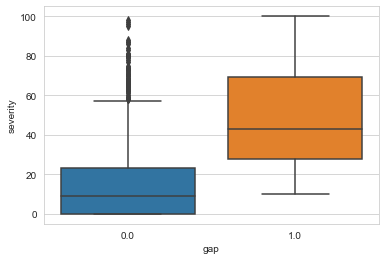

In [37]:
sns.boxplot(y='severity', x='gap', data=df_longformat);

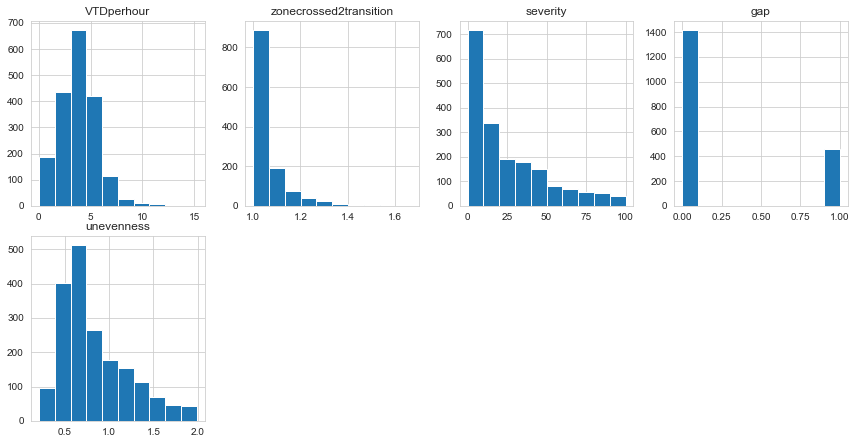

In [38]:
c = 4
l = len(li_mvtha)
fig = plt.figure(figsize=(3*c, 3*l))
for i,v in enumerate(li_mvtha):
    plt.subplot(l,c,i+1)
    plt.tight_layout()
    plt.hist(df_longformat[v]);
    plt.title(v)
    #plt.axis('off');

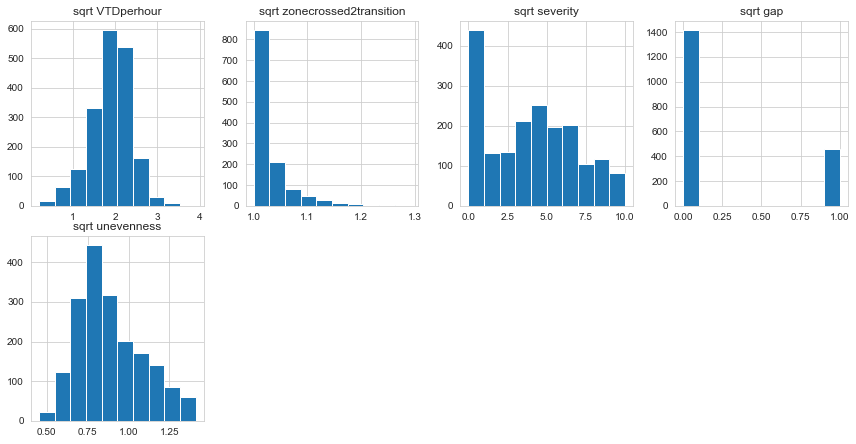

In [39]:
c = 4
l = len(li_mvtha)
fig = plt.figure(figsize=(3*c, 3*l))
for i,v in enumerate(li_mvtha):
    plt.subplot(l,c,i+1)
    plt.tight_layout()
    plt.hist(np.sqrt(df_longformat[v]));
    plt.title('sqrt '+v)
    #plt.axis('off');

In [40]:
df_longformat['ExperimentID'].value_counts()

Exp1    798
Exp2    796
Exp3    634
Name: ExperimentID, dtype: int64

In [41]:
df_longformat['zonecrossed2transition'].describe()

count    1241.000000
mean        1.061943
std         0.083937
min         1.000000
25%         1.011667
50%         1.030000
75%         1.080479
max         1.670196
Name: zonecrossed2transition, dtype: float64